In [2]:
# Install newer version of Pytorch
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

# Cloning ONLY colab-integration branch
from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone -b colab-data-augmentation --single-branch "https://$GITHUB_AUTH@github.com/baltekgajda/LegoSortingRecognition.git"

# Navigate to project folder
os.chdir("./LegoSortingRecognition")





Github user··········
Github password··········
Cloning into 'LegoSortingRecognition'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 189 (delta 99), reused 133 (delta 53), pack-reused 0
Receiving objects: 100% (189/189), 65.16 KiB | 417.00 KiB/s, done.
Resolving deltas: 100% (99/99), done.


In [0]:
# Import necessary libraries
from __future__ import print_function
from __future__ import division
from google.colab import drive
import numpy as np
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import json
import time

from data_loader import load_data
from feature_extraction import train_classifier_only, train_classifier_and_last_conv, train_full_net, train_simplified_net
from net_test_and_metrics import test_network
from svm_classification import train_model_with_svm
import VGGFactory

In [4]:
# Mount Google Drive to access data
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def save_to_json(variable, results_folder, file_name):
  as_json = json.dumps(variable)
  f = open(RESULTS_FOLDER + file_name,"w")
  f.write(as_json)
  f.close()

In [0]:
def save_to_csv(variable, results_folder, file_name):
    np.savetxt(results_folder + file_name, variable, delimiter=',')

In [0]:
def create_folders():
  t = str(time.time())
  root = '/content/drive/My Drive/Studia/SNR'
  current_execution_dir = '/content/drive/My Drive/Studia/SNR/{}'.format(t)
  models_dir = '{}/models/'.format(current_execution_dir)
  results_dir = '{}/results/'.format(current_execution_dir)
  os.chdir(root)
  os.mkdir(current_execution_dir)
  os.mkdir(models_dir)
  os.mkdir(results_dir)
  
  return (models_dir, results_dir)




Initializing Datasets and Dataloaders...
Epoch 0/39
----------
train Loss: 2.9360 Acc: 0.1607
val Loss: 2.8524 Acc: 0.2240
Epoch 1/39
----------
train Loss: 2.7136 Acc: 0.3663
val Loss: 2.6745 Acc: 0.4026
Epoch 2/39
----------
train Loss: 2.6256 Acc: 0.4547
val Loss: 2.6156 Acc: 0.4621
Epoch 3/39
----------
train Loss: 2.5715 Acc: 0.5057
val Loss: 2.5726 Acc: 0.5032
Epoch 4/39
----------
train Loss: 2.5204 Acc: 0.5586
val Loss: 2.5290 Acc: 0.5455
Epoch 5/39
----------
train Loss: 2.4826 Acc: 0.5994
val Loss: 2.4814 Acc: 0.5985
Epoch 6/39
----------
train Loss: 2.4641 Acc: 0.6148
val Loss: 2.4719 Acc: 0.6082
Epoch 7/39
----------
train Loss: 2.4527 Acc: 0.6260
val Loss: 2.4727 Acc: 0.6039
Epoch 8/39
----------
train Loss: 2.4488 Acc: 0.6291
val Loss: 2.4622 Acc: 0.6147
Epoch 9/39
----------
train Loss: 2.4372 Acc: 0.6396
val Loss: 2.4584 Acc: 0.6169
Epoch 10/39
----------
train Loss: 2.4190 Acc: 0.6581
val Loss: 2.4166 Acc: 0.6613
Epoch 11/39
----------
train Loss: 2.4058 Acc: 0.6723
va

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM val Acc: 0.8950
SVM training complete in 42m 33s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM val Acc: 0.9340
SVM training complete in 55m 34s


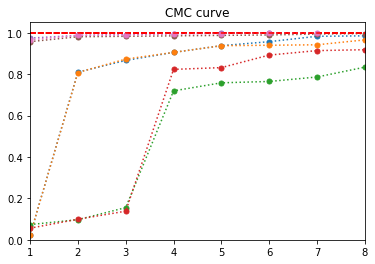

In [8]:
models_dir, results_dir = create_folders()
NUM_OF_CLASSES = 20
NUM_OF_EPOCHS = 40
INPUT_SIZE = 224
DATA_DIR = '/content/drive/My Drive/Studia/SNR/lego/'
MODELS_FOLDER = models_dir
RESULTS_FOLDER = results_dir

print("Initializing Datasets and Dataloaders...")
dataloaders_dict = load_data(DATA_DIR, INPUT_SIZE, batch_size=4, num_workers=4)


if (torch.cuda.is_available() == False):
  raise RuntimeError("GPU is not available!")   
device = torch.device("cuda:0")

torch.cuda.current_device()


model, hist_classifier, test_hist  = train_full_net(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
metrics = test_network(model, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
# save_to_json(test_hist, RESULTS_FOLDER, "test_hist_on_full_net.json")
# save_to_json(hist_classifier, RESULTS_FOLDER, "hist_on_full_net.json")
# save_to_json(metrics, RESULTS_FOLDER, "metrics_on_full_net.json")

# m_simplified, hist_classifier, test_hist  = train_simplified_net(model, dataloaders_dict, MODELS_FOLDER, device, num_of_epochs=NUM_OF_EPOCHS)
# metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
# save_to_json(test_hist, RESULTS_FOLDER, "test_hist_simplified.json")
# save_to_json(hist_classifier, RESULTS_FOLDER, "hist_simplified.json")
# save_to_json(metrics, RESULTS_FOLDER, "metrics_simplified.json")

# model, hist_classifier, test_hist = train_classifier_only(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
# metrics = test_network(model, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
# save_to_json(test_hist, RESULTS_FOLDER, "test_hist_classifier.json")
# save_to_json(hist_classifier, RESULTS_FOLDER, "hist_classifier.json")
# save_to_json(metrics, RESULTS_FOLDER, "metrics_classifier.json")

# model, hist_classifier, test_hist  = train_classifier_and_last_conv(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
# metrics = test_network(model, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
# save_to_json(test_hist, RESULTS_FOLDER, "test_hist_hist_last_conv.json")
# save_to_json(hist_classifier, RESULTS_FOLDER, "hist_last_conv.json")
# save_to_json(metrics, RESULTS_FOLDER, "metrics_last_conv.json")

# svm_model = train_model_with_svm(m_simplified, dataloaders_dict, kernel='l')
# metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc', svm_classifier=svm_model)
# save_to_json(metrics, RESULTS_FOLDER, "metrics_linear_svm.json")

# svm_model = train_model_with_svm(m_simplified, dataloaders_dict, kernel='q')
# metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc', svm_classifier=svm_model)
# save_to_json(metrics, RESULTS_FOLDER, "metrics_quadratic_svm.json")

# svm_model  = train_model_with_svm(m_simplified, dataloaders_dict, kernel='e')
# metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc', svm_classifier=svm_model)
# save_to_json(metrics, RESULTS_FOLDER, "metrics_exponential_svm.json")

Initializing Datasets and Dataloaders...


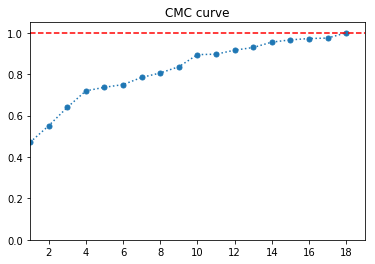

In [19]:
# models_dir, results_dir = create_folders()
# NUM_OF_CLASSES = 20
# NUM_OF_EPOCHS = 40
# INPUT_SIZE = 224
# DATA_DIR = '/content/drive/My Drive/Studia/SNR/lego/'
# MODELS_FOLDER = models_dir
# RESULTS_FOLDER = results_dir

print("Initializing Datasets and Dataloaders...")
dataloaders_dict = load_data(DATA_DIR, INPUT_SIZE, batch_size=4, num_workers=4)


# if (torch.cuda.is_available() == False):
#   raise RuntimeError("GPU is not available!")   
# device = torch.device("cuda:0")

# torch.cuda.current_device()


# FULL_MODEL_PATH = '/content/drive/My Drive/Studia/SNR/augment/models/vgg-full-net.pth'
# model = torch.load(FULL_MODEL_PATH)

# m_simplified, hist_classifier, test_hist  = train_simplified_net(model, dataloaders_dict, MODELS_FOLDER, device, num_of_epochs=NUM_OF_EPOCHS)
m_simplified = m_simplified.eval()
metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
# save_to_json(test_hist, RESULTS_FOLDER, "test_hist_simplified.json")
# save_to_json(hist_classifier, RESULTS_FOLDER, "hist_simplified.json")
save_to_json(metrics, RESULTS_FOLDER, "metrics_simplified.json")

In [0]:
import os
import shutil

os.chdir("/content")
shutil.rmtree('./LegoSortingRecognition')